## Keras CNN Exploration

### Load Libraries

In [53]:
import sys
import os
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 
import warnings 
warnings.filterwarnings('ignore', category=UserWarning)
sys.path.insert(0, '../../')
from library.notebook_api.data_loader import  ModelDataLoader,CombinedDataLoader
from library.notebook_api.model_loader import ModelScenario

### Load Data
load data from data loader and inspect the shape of the features which appears to be variable

In [36]:
model_data_loader = ModelDataLoader('005')
model_data_loader_df = model_data_loader.df
features = model_data_loader.get_mfcc()
labels_series = model_data_loader.df['label']
#array of feature shapes
feature_shapes = [feature.shape[1] for feature in features]
print("features shape distribution")
print(pd.Series(feature_shapes).value_counts())
print("total records: ", len(features))

features shape distribution
2582    13510
2585    10580
2812      583
1         460
1293      357
        ...  
2587        1
2024        1
2455        1
1206        1
1253        1
Name: count, Length: 132, dtype: int64
total records:  25947


In [37]:
#verify matching length
len(labels_series) , len(features)

(25947, 25947)

### Define Filter Based on features

In [38]:
# currently filtered to just the most common shapes, as we'll need to normalize shapes prior to training 
MFCC_LENGTH_CUTOFF = 2582
#array of indexes matching a predicate 
in_scope_feature_indexes = np.where(np.array(feature_shapes) >= MFCC_LENGTH_CUTOFF)[0]
print("normalized length: ",len(in_scope_feature_indexes))

normalized length:  24679


### Encode Labels
assign a numerical index to each string label, then one hot encode the label dataset 

In [39]:
labels_series.value_counts()

label
rock                  7305
experimental          4848
electronic            4114
hiphop                3488
folk                  1286
pop                   1038
classical              997
jazz                   653
international          629
instrumental           483
oldtime / historic     373
country                294
spoken                 270
soulrnb                 82
blues                   79
easy listening           8
Name: count, dtype: int64

In [42]:
#pick subset of labels that are more intuitively representative of genre 
#genres like pop which are ambiguous are removed 
in_scope_labels = ['rock', 'electronic', 'hiphop', 'classical', 'jazz','country']
#optain the indexes of label series wher the label is in the list 
in_scope_label_indexes = np.array(
    (labels_series[
                    labels_series
                        .apply(lambda x: True if x in  in_scope_labels else False)
                ]
                        .index
    )
)

#combine filter for the in scope labels with the same for in scope features 
in_scope_indexes = [index for index in in_scope_label_indexes if index in in_scope_feature_indexes]

print("Row Count after label based filter: ", len(in_scope_label_indexes))
print("Final Row count after label and feature filter: ", len(in_scope_indexes))

Row Count after label based filter:  16851
Final Row count after label and feature filter:  16019


In [43]:
in_scope_label_series = labels_series.iloc[in_scope_indexes]
unique_label_names = in_scope_label_series.unique()
unique_label_count = len(in_scope_label_series.unique())
label_to_int_map = {}
for index, label in enumerate(unique_label_names):
    label_to_int_map[label] = index  


int_to_label_map = {v: k for k, v in label_to_int_map.items()}

#numerical_labels = labels_series.map(label_to_int_map)
numerical_labels = in_scope_label_series.map(label_to_int_map)

encoded_labels = tf.one_hot(indices = numerical_labels.values, depth = len(unique_label_names))

#put to list and reshape again 
#not needed in current implementation
#encoded_labels_array = [label.reshape((unique_label_count,1)) for label in encoded_labels.numpy()]
print("Unique label count: ", unique_label_count)
print("label data count " , len(encoded_labels))

Unique label count:  6
label data count  16019


In [44]:
in_scope_label_series.value_counts()

label
rock          7053
electronic    3745
hiphop        3351
classical      960
jazz           623
country        287
Name: count, dtype: int64

### filter, truncate, reshape features
iterate through the filtered features and build a vector representation appropriate for the CNN input

In [60]:
#truncate to consistent length while reshaping 
reshaped_features = []
feature_array = []
for feature in features[in_scope_indexes]:
    mfcc = [] 
    for vector in feature: 
        mfcc.append(vector[0:MFCC_LENGTH_CUTOFF])
        mfcc_reshaped = np.array(mfcc)
    feature_array.append(mfcc_reshaped)
    reshaped_features.append(mfcc_reshaped.reshape((MFCC_LENGTH_CUTOFF,13,1)))

### Train Test Split

In [116]:
#generate train and test with stratification for equal label distribution across train and test 
TEST_SIZE = .2
X_train, X_test, y_train, y_test = train_test_split(np.array(reshaped_features), encoded_labels.numpy(), test_size=TEST_SIZE, random_state=42, stratify =encoded_labels.numpy() )

#variant with numerical enables, to allow smote f
X_train_, X_test, y_train_, y_test = train_test_split(np.array(feature_array), np.array(numerical_labels), test_size=TEST_SIZE, random_state=42, stratify =np.array(numerical_labels) )



In [117]:
#revised split to use smote
X_train_.shape, y_train_.shape

((12815, 13, 2582), (12815,))

In [118]:
#original split
X_train.shape, y_train.shape

((12815, 2582, 13, 1), (12815, 6))

In [119]:
# optionally apply SMOTE for more balance on training 
smote = SMOTE(random_state=42)
X_train_balance_index, y_train_balanced = smote.fit_resample(np.array(list(range(0,len(X_train_)))).reshape(-1, 1), y_train_)

In [114]:
X_train_balance_index.shape

(33852, 1)

In [139]:
X_train = X_train_[np.array(X_train_balance_index.reshape(X_train_balance_index.shape[0]))]
X_train.shape

(33852, 13, 2582)

In [140]:
X_train =X_train.reshape((len(X_train),MFCC_LENGTH_CUTOFF,13,1))

In [141]:
X_train.shape

(33852, 2582, 13, 1)

In [142]:
y_train_.shape

(12815,)

In [148]:
y_train = np.array(tf.one_hot(indices = y_train_balanced, depth = len(unique_label_names)))

In [149]:
y_train.shape

(33852, 6)

In [107]:
type(y_train)

numpy.ndarray

### Define CNN model

In [150]:
model = keras.Sequential(layers=[
    #https://www.youtube.com/watch?v=dOG-HxpbMSw
    #convulution 1
    keras.layers.Conv2D(32, (3,3), activation=keras.activations.relu),
    keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
    keras.layers.BatchNormalization(),
    #convolution 2
    keras.layers.Conv2D(32, (3,3), activation=keras.activations.relu),
    keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
    keras.layers.BatchNormalization(),
    #convolution 3
    keras.layers.Conv2D(32, (2,2), activation=keras.activations.relu),
    keras.layers.MaxPooling2D((2,2), strides=(2,2), padding='same'),
    keras.layers.BatchNormalization(),
    #flatten and feed into dense layer with dropiut
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation=keras.activations.relu),
    keras.layers.Dropout(0.3),
    #predictions
    keras.layers.Dense(unique_label_count, activation=keras.activations.softmax)
        
    ])
cce = keras.losses.categorical_crossentropy

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss=cce, metrics=['accuracy'])

In [22]:
#note this currently only works after training
#To do figure out how to build model prior to training to inspect it's architectuer
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 2580, 11, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 1290, 6, 32)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 1290, 6, 32)       128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 1288, 4, 32)       9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 644, 2, 32)        0         
 g2D)                                                            
                                                        

### Train Model

In [151]:
#configuration
BATCH_SIZE = 128
#BATCH_SIZE = 64
#BATCH_SIZE = 32
#EPOCHS = 50
EPOCHS = 2
EPOCHS = 2

consider stratified k-fold: https://www.kaggle.com/code/chayannaskar26/stratified-k-fold-cnn
Or smote for imbalance

Epoch 1/2
212/212 [==============================] - 434s 2s/step - loss: 1.7583 - accuracy: 0.2083 - val_loss: 2.3779 - val_accuracy: 0.0012
Epoch 2/2
212/212 [==============================] - 512s 2s/step - loss: 1.7161 - accuracy: 0.2190 - val_loss: 2.8760 - val_accuracy: 5.9075e-04


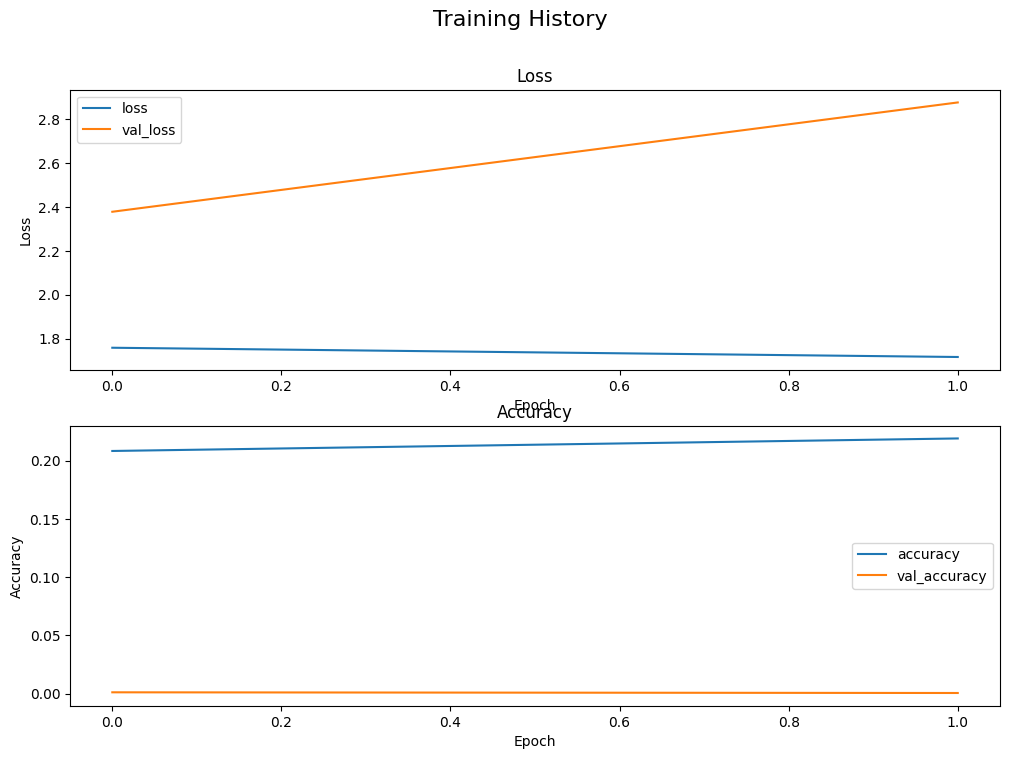

In [152]:
# Train the model
#following reference: https://www.kaggle.com/code/nilshmeier/melspectrogram-based-cnn-classification/notebook
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    #monitor='val_accuracy',
    min_delta = 0,
    patience=5, 
    mode='auto',
    restore_best_weights=True
    )
history = model.fit(x=X_train, y=y_train, validation_split=TEST_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

# Plot the training history
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle('Training History', fontsize=16)
axs[0].plot(history.epoch, history.history['loss'], history.history['val_loss'])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'val_loss'])
axs[1].plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])
plt.show()

In [157]:
X_train.shape

(33852, 2582, 13, 1)

In [ ]:
#to adjust shapes for smote 
#this should be test 
X_test.reshape(X_test.shape[0], X_test.shape[2],X_test.shape[1],1).shape

(3204, 2582, 13, 1)

In [158]:
len(X_test)

3204

In [ ]:
#why needs to be one hot encoded 
y_test.shape

(3204,)

In [130]:
#validation 
y_predicted = np.argmax(model.predict(x=X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
#remap the ints to string names 
label_names = [int_to_label_map[int_label] for int_label in np.unique(numerical_labels)]
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_predicted)
fig = plt.figure()
fig.set_size_inches(12, 8)
sns.heatmap(confusion_matrix, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

101/101 [==============================] - 14s 137ms/step


AxisError: axis 1 is out of bounds for array of dimension 1

In [33]:
[int_to_label_map[int_label] for int_label in label_names]

['hiphop', 'rock', 'electronic', 'jazz', 'country', 'classical']

In [31]:
int_to_label_map

{0: 'hiphop',
 1: 'rock',
 2: 'electronic',
 3: 'jazz',
 4: 'country',
 5: 'classical'}